In [ ]:
#architecture created by Michal Kalinowski based on source https://arxiv.org/ftp/arxiv/papers/1809/1809.10410.pdf

In [ ]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D, concatenate, AveragePooling2D
from tensorflow.keras.layers import Conv2DTranspose, Dropout, Concatenate
from tensorflow.keras.layers import LeakyReLU, Activation, Flatten, Dense, Reshape, InputLayer, Input, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets.fashion_mnist import load_data
from tensorflow.keras.datasets import mnist
from tensorflow.keras import backend as K
import cv2
import os
import matplotlib
import keras
import pandas as pd
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow
import math
from math import log10, sqrt
from skimage.metrics import structural_similarity as ssim
from copy import deepcopy
import random

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
class TestArch():
  def __init__(self):
    pass

  def __enc_block(self, filters = 32, kernel_size = (2,2), input_layer=None, use_maxpool = False):
    input_layer = input_layer
    if use_maxpool:
      input_layer = BatchNormalization()(input_layer)
      input_layer = MaxPooling2D((2,2))(input_layer)
    conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=(1,1), padding = 'same', activation = 'relu')(input_layer)
    conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=(1,1), padding = 'same', activation = 'relu')(conv)
    return conv

  def __dec_block(self, filters = 32, kernel_size = (3,3), input_layer=None, layer_to_concatenate=None, last_layer = False):
    deconv = Conv2DTranspose(filters=filters, kernel_size = kernel_size, strides = (2,2), padding='same', activation='relu')(input_layer)
    if layer_to_concatenate is not None:
      deconv = concatenate([layer_to_concatenate, deconv])
    conv = Conv2D(filters=filters, kernel_size=kernel_size, strides=(1,1), padding = 'same', activation = 'relu')(deconv)
    if last_layer :
      coonv = Conv2D(filters=3, kernel_size=kernel_size, strides=(1,1), padding = 'same', activation = 'sigmoid')(conv)
    return conv
  def __create_model(self):
    input_layer = Input((256,256,3))
    #branch 1
    branch_1_enc_1 = self.__enc_block(filters=32, kernel_size=(3,3), input_layer=input_layer, use_maxpool=False)
    branch_1_enc_2 = self.__enc_block(filters=64, kernel_size=(3,3), input_layer=branch_1_enc_1, use_maxpool=True)
    branch_1_enc_3 = self.__enc_block(filters=128, kernel_size=(3,3), input_layer=branch_1_enc_2, use_maxpool=True)
    branch_1_enc_4 = self.__enc_block(filters=256, kernel_size=(3,3), input_layer=branch_1_enc_3, use_maxpool=True)
    branch_1_enc_5 = self.__enc_block(filters=512, kernel_size=(3,3), input_layer=branch_1_enc_4, use_maxpool=True)
    branch_1_dec_1 = self.__dec_block(filters = 256, input_layer = branch_1_enc_5, layer_to_concatenate=branch_1_enc_4)
    branch_1_dec_2 = self.__dec_block(filters = 128, input_layer = branch_1_dec_1, layer_to_concatenate=branch_1_enc_3)
    branch_1_dec_3 = self.__dec_block(filters = 64, input_layer = branch_1_dec_2, layer_to_concatenate=branch_1_enc_2)
    branch_1_dec_4 = self.__dec_block(filters = 32, input_layer = branch_1_dec_3, layer_to_concatenate=branch_1_enc_1)
    #branch 2
    branch_2_enc_1 = self.__enc_block(filters=32, kernel_size=(3,3), input_layer=input_layer, use_maxpool=False)
    branch_2_enc_2 = self.__enc_block(filters=64, kernel_size=(3,3), input_layer=branch_2_enc_1, use_maxpool=True)
    branch_2_enc_3 = self.__enc_block(filters=128, kernel_size=(3,3), input_layer=branch_2_enc_2, use_maxpool=True)
    branch_2_enc_4 = self.__enc_block(filters=256, kernel_size=(3,3), input_layer=branch_2_enc_3, use_maxpool=True)
    branch_2_dec_1 = self.__dec_block(filters = 128, input_layer = branch_2_enc_4, layer_to_concatenate=branch_2_enc_3)
    branch_2_dec_2 = self.__dec_block(filters = 64, input_layer = branch_2_dec_1, layer_to_concatenate=branch_2_enc_2)
    branch_2_dec_3 = self.__dec_block(filters = 32, input_layer = branch_2_dec_2, layer_to_concatenate=branch_2_enc_1)
    input_concatenation = concatenate([branch_1_dec_4, branch_2_dec_3])
    output_lay = Conv2D(filters=3, kernel_size=(3,3), strides=(1,1), padding = 'same', activation = 'sigmoid')(input_concatenation)
    return Model(input_layer, output_lay)

  def SSIM(self, x_true, x_pred):
    return tf.image.ssim(x_true, x_pred, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)

  def PSNR(self, original_image, reconstructed_image):
    return tf.image.psnr(original_image, reconstructed_image, max_val=1)

  def ssim_loss(self, y_true, y_pred):
    return 1.-tf.image.ssim(y_true, y_pred, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)+1./self.PSNR(y_true, y_pred)
  def make_compiled_model(self):
    model = self.__create_model()
    model.compile(loss=self.ssim_loss, optimizer=Adam(learning_rate=0.001), metrics=[self.SSIM, self.PSNR])
    return model
model = TestArch().make_compiled_model()

In [ ]:
#train data
try:
  del imageNoise
  del imageClear
except Exception:
  pass
#image with reflects
start_loading = 0
end_loading = 1195
imageNoise = []
for i in range(start_loading, end_loading):
  image = cv2.imread(f'/content/drive/MyDrive/baza/database/reflects/im{i}.jpg')
  if type(image) is not type(None):
    imageNoise.append(image)
imageNoise = np.array(imageNoise, dtype='object')
#image without reflects
imageClear = []
for i in range(start_loading, end_loading):
  image = cv2.imread(f'/content/drive/MyDrive/baza/database/clear/im{i}.jpg')
  if type(image) is not type(None):
    imageClear.append(image)
imageClear = np.array(imageClear, dtype='object')

imageNoise = imageNoise.astype('float32') / 255
imageClear = imageClear.astype('float32') / 255

#validation data
try:
  del imageNoise_valid
  del imageClear_valid
except Exception:
  pass
#image with reflects
imageNoise_valid = []
for i in range(0, 520):
  image = cv2.imread(f'/content/drive/MyDrive/baza/test_base/valid/reflects/im{i}.jpg')
  if type(image) is not type(None):
    imageNoise_valid.append(image)
imageNoise_valid = np.array(imageNoise_valid, dtype='object')
imageNoise_valid = imageNoise_valid.astype('float32')
#image without reflects
imageClear_valid = []
for i in range(0, 520):
  image = cv2.imread(f'/content/drive/MyDrive/baza/test_base/valid/true/im{i}.jpg')
  if type(image) is not type(None):
    imageClear_valid.append(image)
imageClear_valid = np.array(imageClear_valid, dtype='object')
imageClear_valid = imageClear_valid.astype('float32')

#imageNoise_valid = np.array([prepare_image( imageClear_valid[idx] ) for idx in range(len(imageClear_valid))], dtype='object')
#dataset normalization
imageNoise_valid = imageNoise_valid / 255.
imageClear_valid = imageClear_valid / 255.


In [ ]:
if imageClear.shape == imageNoise.shape:
  print(imageClear.shape, imageNoise.shape)
  train_history = model.fit(
    imageNoise ,
    imageClear ,
    epochs= 110,
    shuffle=True,
    batch_size = 16,
    validation_data = (imageNoise_valid, imageClear_valid)
)

(1195, 256, 256, 3) (1195, 256, 256, 3)
Epoch 1/110
75/75 [==============================] - 148s 2s/step - loss: 0.2134 - SSIM: 0.8335 - PSNR: 22.9126 - val_loss: 0.2814 - val_SSIM: 0.7772 - val_PSNR: 17.7479
Epoch 2/110
75/75 [==============================] - 109s 1s/step - loss: 0.1095 - SSIM: 0.9263 - PSNR: 28.3718 - val_loss: 0.2477 - val_SSIM: 0.8074 - val_PSNR: 18.7101
Epoch 3/110
75/75 [==============================] - 109s 1s/step - loss: 0.0967 - SSIM: 0.9381 - PSNR: 29.2111 - val_loss: 0.1994 - val_SSIM: 0.8487 - val_PSNR: 21.1121
Epoch 4/110
75/75 [==============================] - 109s 1s/step - loss: 0.0890 - SSIM: 0.9444 - PSNR: 30.3513 - val_loss: 0.1865 - val_SSIM: 0.8603 - val_PSNR: 21.7471
Epoch 5/110
75/75 [==============================] - 109s 1s/step - loss: 0.0772 - SSIM: 0.9544 - PSNR: 31.9875 - val_loss: 0.1459 - val_SSIM: 0.8950 - val_PSNR: 24.6482
Epoch 6/110
75/75 [==============================] - 109s 1s/step - loss: 0.0708 - SSIM: 0.9600 - PSNR: 32.885

In [ ]:
tf.keras.models.save_model( model, 'drive/MyDrive/model/tests/double_unet_150.h5' )

In [ ]:
def SSIM( x_true, x_pred):
  return tf.image.ssim(x_true, x_pred, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
def PSNR(original_image, reconstructed_image):
  return tf.image.psnr(original_image, reconstructed_image, max_val=1)
def SSIM(x_true, x_pred):
  return tf.image.ssim(x_true, x_pred, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
def PSNR(original_image, reconstructed_image):
  return tf.image.psnr(original_image, reconstructed_image, max_val=1)

def ssim_loss(y_true, y_pred):
  return 1.-tf.image.ssim(y_true, y_pred, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)+1./self.PSNR(y_true, y_pred)

def NAE(original_image, reconstructed_image):
        #
        return np.sum(np.abs(original_image-reconstructed_image))/np.sum(original_image)
def SC( original_image, reconstructed_image):
        #
        return np.sum(original_image**2)/np.sum(reconstructed_image**2)
clear_test = []
noised_test = []
path_clear = 'drive/MyDrive/baza/database/test/clear/'
path_noise = 'drive/MyDrive/baza/database/test/noise/'

for image in os.listdir(path_clear):
  image_clear = cv2.imread(os.path.join(path_clear, image))
  image_noisy = cv2.imread(os.path.join(path_noise, image))
  if image_clear.shape < (256,256,3):
    image_clear = tf.image.resize(image_clear, (256,256))
    image_clear = np.array(image_clear, dtype='object')
  if image_noisy.shape < (256,256,3):
    image_noisy = tf.image.resize(image_noisy, (256,256))
    image_noisy = np.array(image_noisy, dtype='object')
  clear_test.append(image_clear)
  noised_test.append(image_noisy)

clear_test = np.array(clear_test, dtype='object')
clear_test = clear_test.astype('float32') / 255.

noised_test = np.array(noised_test, dtype='object')
noised_test = noised_test.astype('float32') / 255.
prediction = model.predict(noised_test)
psnr = np.average([PSNR(clear_test[idx], prediction[idx]) for idx in range(101)])
ssim = np.average([SSIM(clear_test[idx], prediction[idx]) for idx in range(101)])
#fsim = np.average([fsim(clear_test[idx], prediction[idx]) for idx in range(101)])
nae = np.average([NAE(clear_test[idx], prediction[idx]) for idx in range(101)])
sc = np.average([SC(clear_test[idx], prediction[idx]) for idx in range(101)])
print(f'SSIM : {ssim:.3f} PSNR : {psnr:.3f}  NAE : {nae:.3f} SC : {sc:.3f}')

SSIM : 0.973 PSNR : 38.142  NAE : 0.022 SC : 1.020


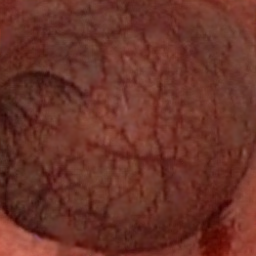

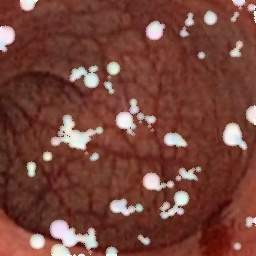

In [ ]:
idx = 99
cv2_imshow(prediction[idx] * 255.)
cv2_imshow(noised_test[idx] * 255.)